In [1]:
import nltk
from nltk import FreqDist
#nltk.download('stopwords') # run this one time

In [2]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

D:\Tools\Anaconda\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [3]:
#df = pd.read_json('meta_AMAZON_FASHION.json', lines=True)
review = pd.read_json('AMAZON_FASHION.json', lines=True)

In [4]:
review.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,My New 'Friends' !!,1408924800,NaN,NaN,NaN


In [5]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883636 entries, 0 to 883635
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         883636 non-null  int64  
 1   verified        883636 non-null  bool   
 2   reviewTime      883636 non-null  object 
 3   reviewerID      883636 non-null  object 
 4   asin            883636 non-null  object 
 5   reviewerName    883544 non-null  object 
 6   reviewText      882403 non-null  object 
 7   summary         883103 non-null  object 
 8   unixReviewTime  883636 non-null  int64  
 9   vote            79900 non-null   float64
 10  style           304569 non-null  object 
 11  image           28807 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 75.0+ MB


In [6]:
review = review.dropna(subset=["reviewText"])

In [7]:
review = review.dropna(subset=["summary"])

In [8]:
review.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,My New 'Friends' !!,1408924800,NaN,NaN,NaN


### Data Preprocessing

In [9]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

D:\Tools\Anaconda\lib\site-packages\seaborn\categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
D:\Tools\Anaconda\lib\site-packages\seaborn\utils.py:551: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


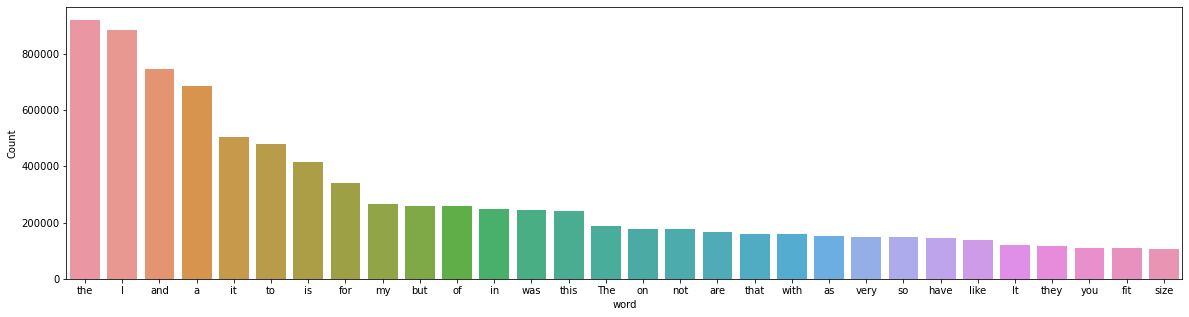

In [10]:
freq_words(review['reviewText'])

In [11]:
df = review['reviewText'].to_frame()
#df[['reviewText']]

In [35]:
#remove stop words as evidenced from previous diagram

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to C:\Users\Arthur
[nltk_data]     Wen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [13]:
stop = set(stopwords.words('english'))

In [14]:
df['noStopword'] = df['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

D:\Tools\Anaconda\lib\site-packages\seaborn\categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
D:\Tools\Anaconda\lib\site-packages\seaborn\utils.py:551: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


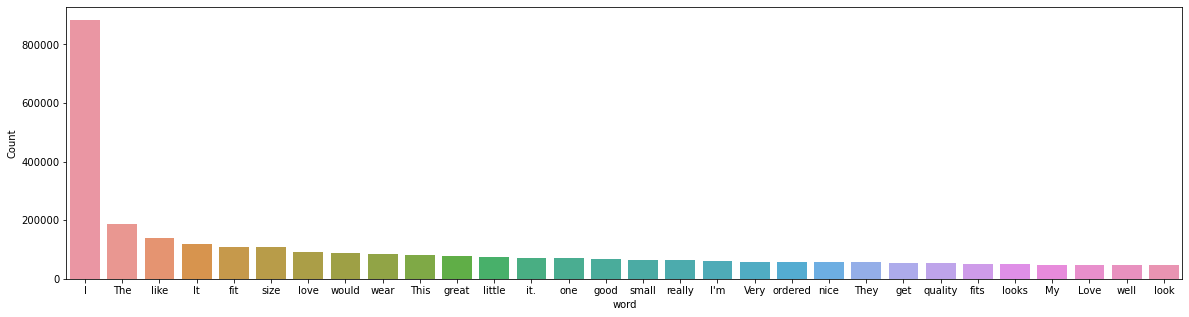

In [15]:
freq_words(df['noStopword'])

In [40]:
df['noStopword'] = df['noStopword'].str.replace("[^a-zA-Z#]", " ")
df['noStopword'] = df['noStopword'].str.lower()

<ipython-input-40-6a3f8751ceac>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['noStopword'] = df['noStopword'].str.replace("[^a-zA-Z#]", " ")


In [17]:
df['tokenized'] = df['noStopword'].apply(nltk.word_tokenize)

In [18]:
df['tagged'] = df['tokenized'].apply(nltk.pos_tag)

In [19]:
df['nouns'] = df['tagged'].apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNS', 'NNP', 'NNPS']])

In [20]:
df['verbs'] = df['tagged'].apply(lambda x: [word for word, tag in x if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']])

In [21]:
df['adjs'] = df['tagged'].apply(lambda x: [word for word, tag in x if tag.startswith("J")])

In [22]:
df['adverbs'] = df['tagged'].apply(lambda x: [word for word, tag in x if tag.startswith("RB")])

In [23]:
df.head()

,reviewText,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs
0,Exactly what I needed.,Exactly I needed.,"[Exactly, I, needed, .]","[(Exactly, RB), (I, PRP), (needed, VBD), (., .)]",[],[needed],[],[Exactly]
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree review, opening small. I almost bent hook expensive earrings trying get higher end they're seen. Would buy price, sending back.","[I, agree, review, ,, opening, small, ., I, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, 're, seen, ., Would, buy, price, ,, sending, back, .]","[(I, PRP), (agree, VBP), (review, NN), (,, ,), (opening, VBG), (small, JJ), (., .), (I, PRP), (almost, RB), (bent, VBD), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (hi...","[review, hook, earrings, end, price]","[agree, opening, bent, trying, get, 're, seen, buy, sending]","[small, expensive, higher]","[almost, back]"
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,Love these... I going order another pack keep work; someone (including myself) always losing back earring. I understand fish hook earrings them. Just wish tiny bit longer. :),"[Love, these, ..., I, going, order, another, pack, keep, work, ;, someone, (, including, myself, ), always, losing, back, earring, ., I, understand, fish, hook, earrings, them, ., Just, wish, tiny...","[(Love, VB), (these, DT), (..., :), (I, PRP), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (;, :), (someone, NN), ((, (), (including, VBG), (myself, PRP), (), )), ...","[order, pack, keep, work, someone, hook, bit]","[Love, going, including, losing, earring, understand, earrings]","[fish, wish, tiny]","[always, Just, longer]"
3,too tiny an opening,tiny opening,"[tiny, opening]","[(tiny, JJ), (opening, NN)]",[opening],[],[tiny],[]
4,Okay,Okay,[Okay],"[(Okay, NN)]",[Okay],[],[],[]


In [24]:
df['Token_Count'] = df['tokenized'].str.len()

In [25]:
def norm_lemm_v_a_func(text):
    '''
    Lemmatize tokens from string
    
    Step 1: Use word_tokenize() to get tokens from string
    Step 2: Use WordNetLemmatizer() with POS tag 'v' to lemmatize the created tokens
    Step 3: Use word_tokenize() to get tokens from generated string        
    Step 4: Use WordNetLemmatizer() with POS tag 'a' to lemmatize the created tokens
    
    Args:
        text (str): String to which the functions are to be applied, string
    
    Returns:
        String with lemmatized words
    '''
    words1 = word_tokenize(text)
    text1 = ' '.join([WordNetLemmatizer().lemmatize(word, pos='v') for word in words1])
    words2 = word_tokenize(text1)
    text2 = ' '.join([WordNetLemmatizer().lemmatize(word, pos='a') for word in words2])
    return text2

def norm_lemm_v_a_func_token(text):
    '''
    Lemmatize tokens from string
    
    Step 1: Use word_tokenize() to get tokens from string
    Step 2: Use WordNetLemmatizer() with POS tag 'v' to lemmatize the created tokens
    Step 3: Use word_tokenize() to get tokens from generated string        
    Step 4: Use WordNetLemmatizer() with POS tag 'a' to lemmatize the created tokens
    
    Args:
        text (str): String to which the functions are to be applied, string
    
    Returns:
        String with lemmatized words
    '''

    text1 = [WordNetLemmatizer().lemmatize(word, pos='v') for word in text]
    text2 = [WordNetLemmatizer().lemmatize(word, pos='a') for word in text1]
    return text2

In [26]:
df['lemmatized'] = df['noStopword'].apply(norm_lemm_v_a_func)

In [27]:
df.head()

,reviewText,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs,Token_Count,lemmatized
0,Exactly what I needed.,Exactly I needed.,"[Exactly, I, needed, .]","[(Exactly, RB), (I, PRP), (needed, VBD), (., .)]",[],[needed],[],[Exactly],4,Exactly I need .
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree review, opening small. I almost bent hook expensive earrings trying get higher end they're seen. Would buy price, sending back.","[I, agree, review, ,, opening, small, ., I, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, 're, seen, ., Would, buy, price, ,, sending, back, .]","[(I, PRP), (agree, VBP), (review, NN), (,, ,), (opening, VBG), (small, JJ), (., .), (I, PRP), (almost, RB), (bent, VBD), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (hi...","[review, hook, earrings, end, price]","[agree, opening, bent, trying, get, 're, seen, buy, sending]","[small, expensive, higher]","[almost, back]",28,"I agree review , open small . I almost bend hook expensive earrings try get high end they 're see . Would buy price , send back ."
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,Love these... I going order another pack keep work; someone (including myself) always losing back earring. I understand fish hook earrings them. Just wish tiny bit longer. :),"[Love, these, ..., I, going, order, another, pack, keep, work, ;, someone, (, including, myself, ), always, losing, back, earring, ., I, understand, fish, hook, earrings, them, ., Just, wish, tiny...","[(Love, VB), (these, DT), (..., :), (I, PRP), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (;, :), (someone, NN), ((, (), (including, VBG), (myself, PRP), (), )), ...","[order, pack, keep, work, someone, hook, bit]","[Love, going, including, losing, earring, understand, earrings]","[fish, wish, tiny]","[always, Just, longer]",36,Love these ... I go order another pack keep work ; someone ( include myself ) always lose back earring . I understand fish hook earrings them . Just wish tiny bite long . : )
3,too tiny an opening,tiny opening,"[tiny, opening]","[(tiny, JJ), (opening, NN)]",[opening],[],[tiny],[],2,tiny open
4,Okay,Okay,[Okay],"[(Okay, NN)]",[Okay],[],[],[],1,Okay


### EDA

In [28]:
def remove_single_char_func(text, threshold=1):
    '''
    Removes single characters from string, if present
    
    Step 1: Use word_tokenize() to get tokens from string
    Step 2: Removes words whose length falls below the threshold (by default = 1)
    
    Args:
        text (str): String to which the functions are to be applied, string
    
    Returns:
        String with removed words whose length was below the threshold (by default = 1)
    ''' 
    threshold = threshold
    
    words = word_tokenize(text)
    text = ' '.join([word for word in words if len(word) > threshold])
    return text

In [29]:
df['clean'] = df['lemmatized'].apply(remove_single_char_func)
df['clean'] = df.apply(lambda x: remove_single_char_func(x["lemmatized"], threshold=2), axis = 1)

In [30]:
df.head()

,reviewText,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs,Token_Count,lemmatized,clean
0,Exactly what I needed.,Exactly I needed.,"[Exactly, I, needed, .]","[(Exactly, RB), (I, PRP), (needed, VBD), (., .)]",[],[needed],[],[Exactly],4,Exactly I need .,Exactly need
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree review, opening small. I almost bent hook expensive earrings trying get higher end they're seen. Would buy price, sending back.","[I, agree, review, ,, opening, small, ., I, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, 're, seen, ., Would, buy, price, ,, sending, back, .]","[(I, PRP), (agree, VBP), (review, NN), (,, ,), (opening, VBG), (small, JJ), (., .), (I, PRP), (almost, RB), (bent, VBD), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (hi...","[review, hook, earrings, end, price]","[agree, opening, bent, trying, get, 're, seen, buy, sending]","[small, expensive, higher]","[almost, back]",28,"I agree review , open small . I almost bend hook expensive earrings try get high end they 're see . Would buy price , send back .",agree review open small almost bend hook expensive earrings try get high end they 're see Would buy price send back
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,Love these... I going order another pack keep work; someone (including myself) always losing back earring. I understand fish hook earrings them. Just wish tiny bit longer. :),"[Love, these, ..., I, going, order, another, pack, keep, work, ;, someone, (, including, myself, ), always, losing, back, earring, ., I, understand, fish, hook, earrings, them, ., Just, wish, tiny...","[(Love, VB), (these, DT), (..., :), (I, PRP), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (;, :), (someone, NN), ((, (), (including, VBG), (myself, PRP), (), )), ...","[order, pack, keep, work, someone, hook, bit]","[Love, going, including, losing, earring, understand, earrings]","[fish, wish, tiny]","[always, Just, longer]",36,Love these ... I go order another pack keep work ; someone ( include myself ) always lose back earring . I understand fish hook earrings them . Just wish tiny bite long . : ),Love these ... order another pack keep work someone include myself always lose back earring understand fish hook earrings them Just wish tiny bite long
3,too tiny an opening,tiny opening,"[tiny, opening]","[(tiny, JJ), (opening, NN)]",[opening],[],[tiny],[],2,tiny open,tiny open
4,Okay,Okay,[Okay],"[(Okay, NN)]",[Okay],[],[],[],1,Okay,Okay


In [59]:
df.to_csv("FASHION_review_cleaned.csv")

D:\Tools\Anaconda\lib\site-packages\seaborn\categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
D:\Tools\Anaconda\lib\site-packages\seaborn\utils.py:551: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


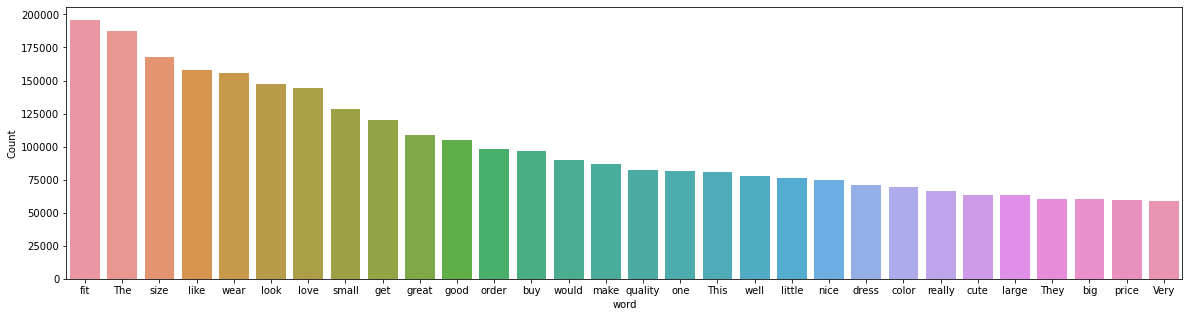

In [31]:
freq_words(df['clean'])

In [32]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

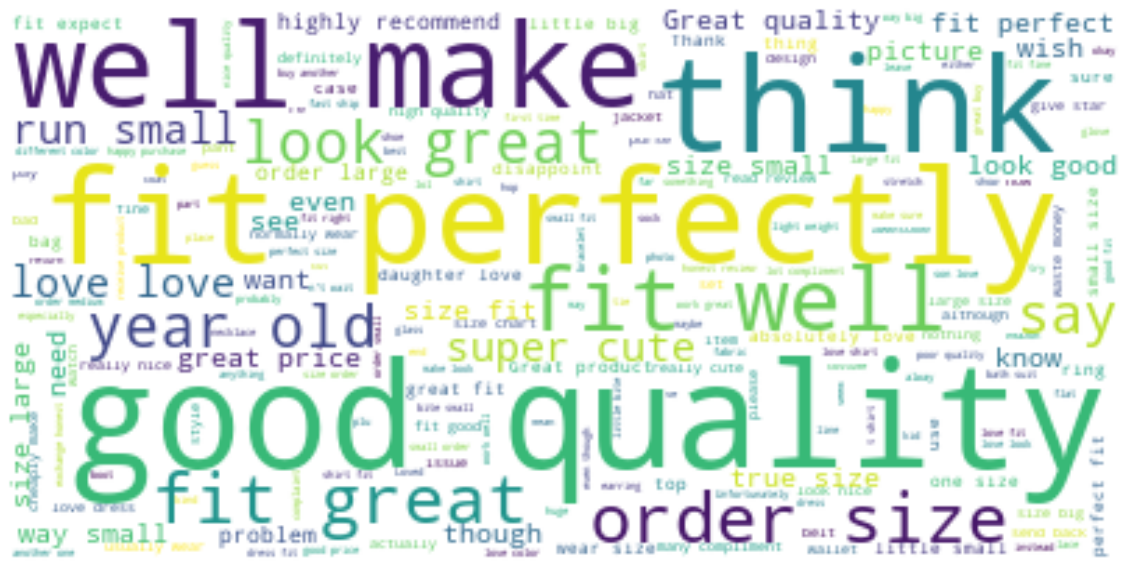

In [33]:
text = " ".join(i for i in df['clean'])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Feature Extraction

In [34]:
from nltk.collocations import *
from nltk.util import ngrams

In [35]:
word_list = ' '.join([i for i in df['clean']]).split()

In [36]:
(pd.Series(nltk.ngrams(word_list, 2)).value_counts())[:20]

(look, like)        21070
(fit, perfectly)    15549
(good, quality)     14567
(well, make)        13778
(fit, well)         13344
(like, picture)     12907
(order, size)       11975
(look, great)       11964
(year, old)         11130
(fit, great)        11004
(run, small)        10150
(The, material)     10121
(really, like)       9922
(love, them)         9387
(look, good)         9065
(fit, perfect)       8970
(Very, nice)         8741
(size, small)        8441
(fit, like)          8063
(The, color)         7859
dtype: int64

In [37]:
(pd.Series(nltk.ngrams(word_list, 3)).value_counts())[:20]

(look, like, picture)             3877
(get, pay, for)                   2902
(get, lot, compliment)            2594
(get, many, compliment)           2492
(receive, product, discount)      2492
(honest, unbiased, review)        2260
(exchange, honest, review)        2002
(nothing, like, picture)          1950
(discount, exchange, honest)      1836
(exchange, honest, unbiased)      1830
(order, size, large)              1710
(exactly, like, picture)          1572
(n't, wait, wear)                 1529
(receive, many, compliment)       1482
(year, old, daughter)             1437
(run, little, small)              1429
(look, nothing, like)             1410
(would, definitely, recommend)    1401
(one, size, fit)                  1397
(Love, love, love)                1348
dtype: int64

In [38]:
search_word = ["love", "like", "hate", "great", "nice", 'the']

no_opinion = ' '.join((filter(lambda val: val not in search_word, list(word_list)))).split()

In [39]:
(pd.Series(nltk.ngrams(no_opinion, 2)).value_counts())[:20]

(fit, perfectly)      15552
(good, quality)       14602
(well, make)          13779
(fit, well)           13389
(order, size)         12003
(year, old)           11130
(run, small)          10157
(The, material)       10121
(look, good)           9281
(fit, perfect)         9030
(size, small)          8470
(The, color)           7862
(would, recommend)     7629
(think, would)         7363
(they, 're)            7301
(size, fit)            7174
(size, large)          6963
(true, size)           6855
(Very, cute)           6737
(little, small)        6623
dtype: int64

In [40]:
(pd.Series(nltk.ngrams(no_opinion, 3)).value_counts())[:20]

(get, pay, for)                   2902
(get, lot, compliment)            2601
(get, many, compliment)           2507
(receive, product, discount)      2499
(honest, unbiased, review)        2260
(exchange, honest, review)        2002
(discount, exchange, honest)      1836
(exchange, honest, unbiased)      1830
(order, size, large)              1711
(n't, wait, wear)                 1530
(receive, many, compliment)       1493
(year, old, daughter)             1441
(run, little, small)              1429
(one, size, fit)                  1403
(would, definitely, recommend)    1401
(look, exactly, picture)          1296
(fit, true, size)                 1283
(order, one, size)                1257
(would, buy, again)               1253
(You, get, pay)                   1240
dtype: int64

## Sentiment Analysis

In [41]:
review['overall'].value_counts()
df['rating'] = review['overall']

In [42]:
def label_func(rating):
    if rating <= 2:
        return 'negative'
    if rating >= 4:
        return 'positive'
    else:
        return 'neutral'

df['sentiment'] = df['rating'].apply(label_func)

In [43]:
positive_review = df[(df["sentiment"] == 'positive')]['clean'].to_frame()
neutral_review = df[(df["sentiment"] == 'neutral')]['clean'].to_frame()
negative_review = df[(df["sentiment"] == 'negative')]['clean'].to_frame()

In [44]:
pos_clean = ' '.join([i for i in positive_review['clean']]).split()
neutral_clean = ' '.join([i for i in neutral_review['clean']]).split()
neg_clean = ' '.join([i for i in negative_review['clean']]).split()

In [45]:
pos_clean = ' '.join((filter(lambda val: val not in search_word, list(pos_clean)))).split()
neutral_clean = ' '.join((filter(lambda val: val not in search_word, list(neutral_clean)))).split()
neg_clean = ' '.join((filter(lambda val: val not in search_word, list(neg_clean)))).split()

In [46]:
text_corpus_positive_review = ' '.join(pos_clean)
text_corpus_neutral_review = ' '.join(neutral_clean)
text_corpus_negative_review = ' '.join(neg_clean)

In [47]:
def most_common_word_func(text, n_words=25):

    words = word_tokenize(text)
    fdist = FreqDist(words) 
    
    n_words = n_words
    
    df_fdist = pd.DataFrame({'Word': fdist.keys(),
                             'Frequency': fdist.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False).head(n_words)
    
    return df_fdist

In [48]:
df_most_common_words_text_corpus_positive_review = most_common_word_func(text_corpus_positive_review)
df_most_common_words_text_corpus_neutral_review = most_common_word_func(text_corpus_neutral_review)
df_most_common_words_text_corpus_negative_review = most_common_word_func(text_corpus_negative_review)

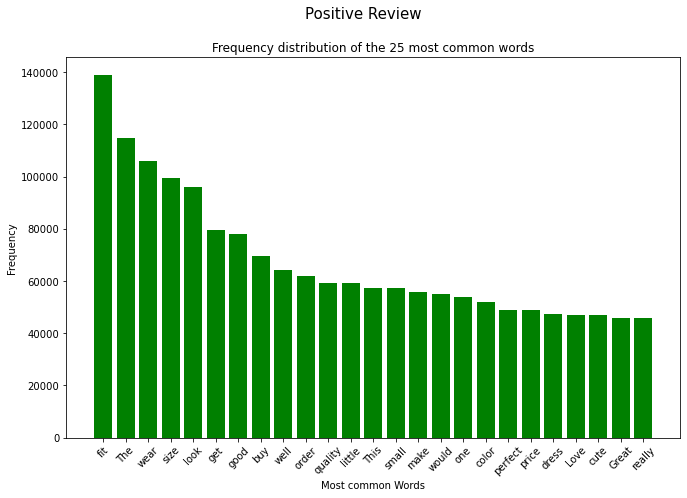

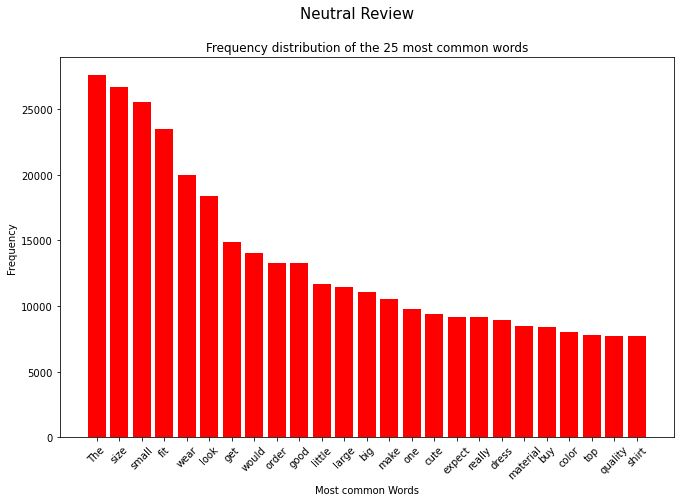

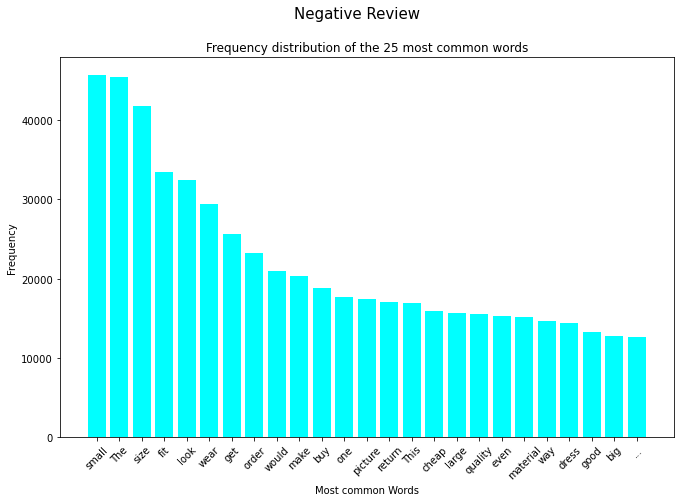

In [49]:
splited_data = [df_most_common_words_text_corpus_positive_review,
                df_most_common_words_text_corpus_neutral_review,
                df_most_common_words_text_corpus_negative_review]

color_list = ['green', 'red', 'cyan']
title_list = ['Positive Review', 'Neutral Review', 'Negative Review']


for item in range(3):
    plt.figure(figsize=(11,7))
    plt.bar(splited_data[item]['Word'], 
            splited_data[item]['Frequency'],
            color=color_list[item])
    plt.xticks(rotation = 45)
    plt.xlabel('Most common Words')
    plt.ylabel("Frequency")
    plt.title("Frequency distribution of the 25 most common words")
    plt.suptitle(title_list[item], fontsize=15)
    plt.show()

## Topic Modeling

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

dictionary = corpora.Dictionary(df['tokenized'])

In [77]:
doc_term_matrix = [dictionary.doc2bow(word) for word in df['tokenized']]

In [78]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [192]:
##lda_model_1 = Lda_object(DT_matrix, num_topics=2, id2word = dictionary)

print(lda_model.print_topics(num_topics=6, num_words=5))

[(4, '0.113*"needed" + 0.045*"use" + 0.039*"trying" + 0.023*"new" + 0.023*"level"'), (2, '0.052*"new" + 0.042*"instead" + 0.025*"heartbeat" + 0.025*"came" + 0.023*"choose"'), (3, '0.055*"kudos" + 0.034*"apart" + 0.031*"holes" + 0.026*"to" + 0.026*"years"'), (5, '0.119*"needed" + 0.017*"would" + 0.014*"shame" + 0.011*"wish" + 0.011*"three"'), (6, '0.164*"pack" + 0.085*"new" + 0.068*"needed" + 0.029*"usa" + 0.029*"much"'), (1, '0.050*"needed" + 0.033*"apart" + 0.023*"securely" + 0.023*"new" + 0.012*"stretching"')]


In [539]:
from textblob import TextBlob

df = df[df.Token_Count>2] # Whole Dataset

def norm_lemm_v_a_func_token(text):
    '''
    Lemmatize tokens
    
    Step 1: Use WordNetLemmatizer() with POS tag 'v' to lemmatize the created tokens     
    Step 2: Use WordNetLemmatizer() with POS tag 'a' to lemmatize the created tokens
    
    Args:
        text (str): String to which the functions are to be applied, string
    
    Returns:
        String with lemmatized words
    '''

    text1 = [WordNetLemmatizer().lemmatize(word, pos='v') for word in text]
    text2 = [WordNetLemmatizer().lemmatize(word, pos='a') for word in text1]
    return text2

# Filter out nouns (product-related features), verbs and subjective adverbs & adjs which reflect strong customer opinions.
word_len_threshold = 2
df['tagged_filtered'] = df['tagged'].apply(lambda x: [word for word, tag in x 
                                                    if len(word) > word_len_threshold and
                                                        (   tag.startswith("N") 
                                                        or tag.startswith("V")
                                                        or (tag.startswith("RB") and TextBlob(word).sentiment.subjectivity>0)
                                                        or (tag.startswith("J") and TextBlob(word).sentiment.subjectivity>0)  )])

df["tokenized_filtered"] = df['tagged_filtered'].apply(norm_lemm_v_a_func_token)

df

,reviewTime,reviewerID,reviewerName,vote,reviewText,noStopword,tokenized,tagged,nouns,verbs,...,rating,sentiment,adjs,bigram,adverbs,day_gap,year-month,year,tagged_filtered,tokenized_filtered
0,2014-10-20,A1D4G1SNUZWQOT,Tracy,0.0,Exactly what I needed.,exactly i needed,"[exactly, i, needed]","[(exactly, RB), (i, NN), (needed, VBD)]",[i],[needed],...,5,positive,[],[exactly need],[exactly],1442,2014-10,2014,"[exactly, needed]","[exactly, need]"
1,2014-09-28,A3DDWDH9PX2YX2,Sonja Lau,3.0,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree review opening small i almost bent hook expensive earrings trying get higher end they re seen would buy price sending back,"[i, agree, review, opening, small, i, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, re, seen, would, buy, price, sending, back]","[(i, JJ), (agree, VBP), (review, NN), (opening, VBG), (small, JJ), (i, NN), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, N...","[review, i, hook, earrings, end, price]","[agree, opening, trying, get, re, seen, buy, sending]",...,2,negative,"[i, small, bent, expensive, higher]","[agree review, review open, open small, small almost, almost bend, bend hook, hook expensive, expensive earrings, earrings try, try get, get high, high end, end they, they see, see would, would bu...",[almost],1464,2014-09,2014,"[agree, review, opening, small, hook, expensive, earrings, trying, get, higher, end, seen, buy, price, sending]","[agree, review, open, small, hook, expensive, earrings, try, get, high, end, see, buy, price, send]"
2,2014-08-25,A2MWC41EW7XL15,Kathleen,0.0,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i going order another pack keep work someone including myself always losing back earring i understand fish hook earrings them just wish tiny bit longer,"[love, these, i, going, order, another, pack, keep, work, someone, including, myself, always, losing, back, earring, i, understand, fish, hook, earrings, them, just, wish, tiny, bit, longer]","[(love, IN), (these, DT), (i, NNS), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (myself, PRP), (always, RB), (losing, VBG), (back...","[i, order, pack, keep, work, someone, i, hook, bit]","[going, including, losing, earring, understand, earrings, wish]",...,4,positive,"[fish, tiny]","[love these, these order, order another, another pack, pack keep, keep work, work someone, someone include, include myself, myself always, always lose, lose back, back earring, earring understand,...","[always, just, longer]",1498,2014-08,2014,"[going, order, pack, keep, work, someone, including, losing, earring, understand, hook, earrings, wish, tiny, bit]","[go, order, pack, keep, work, someone, include, lose, earring, understand, hook, earrings, wish, tiny, bite]"
5,2014-07-19,A29HLOUW0NS0EH,Patricia R. Erwin,0.0,Exactly what I wanted.,exactly i wanted,"[exactly, i, wanted]","[(exactly, RB), (i, RB), (wanted, VBD)]",[],[wanted],...,5,positive,[],[exactly want],"[exactly, i]",1535,2014-07,2014,"[exactly, wanted]","[exactly, want]"
6,2014-05-31,A7QS961ROI6E0,REBECCA S LAYTON,0.0,"These little plastic backs work great. No more loosing ""hook"" earrings! Wish I had ordered these sooner before I had lost some of my favorite earrings!",these little plastic backs work great no loosing hook earrings wish i ordered sooner i lost favorite earrings,"[these, little, plastic, backs, work, great, no, loosing, hook, earrings, wish, i, ordered, sooner, i, lost, favorite, earrings]","[(these, DT), (little, JJ), (plastic, NN), (backs, NNS), (work, VBP), (great, JJ), (no,

In [540]:
# Divide dictonary into three sentiment states to understand the main user opinions in each of them.
df_pos = df[df.sentiment=="positive"]
df_neu = df[df.sentiment=="neutral"]
df_neg = df[df.sentiment=="negative"]

pos_dictionary = corpora.Dictionary(df_pos['tokenized_filtered'])
neu_dictionary = corpora.Dictionary(df_neu['tokenized_filtered'])
neg_dictionary = corpora.Dictionary(df_neg['tokenized_filtered'])

# Filter out tokens appear in 1) less than 1% of all reviews. (less representative) (no ) 2) more than 80% of all reviews (no benefit for topic distinguishing).
pos_dictionary.filter_extremes(no_below=0.01*len(pos_dictionary.token2id), no_above=0.8) 
neu_dictionary.filter_extremes(no_below=0.01*len(neu_dictionary.token2id), no_above=0.8) 
neg_dictionary.filter_extremes(no_below=0.01*len(neg_dictionary.token2id), no_above=0.8)

pos_doc_term_matrix = [pos_dictionary.doc2bow(word) for word in df_pos['tokenized_filtered']]
neu_doc_term_matrix = [neu_dictionary.doc2bow(word) for word in df_neu['tokenized_filtered']]
neg_doc_term_matrix = [neg_dictionary.doc2bow(word) for word in df_neg['tokenized_filtered']]

In [541]:
# LDA model parameter tuning

# from gensim.test.utils import common_texts
# from gensim.corpora.dictionary import Dictionary

# lda = gensim.models.ldamodel.LdaModel(corpus=pos_doc_term_matrix,
#                                            #id2word=pos_dictionary,
#                                            num_topics=20, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)

pos_lda_model = LDA(corpus=pos_doc_term_matrix, id2word=pos_dictionary, num_topics=10, random_state=100, chunksize=100, passes=10)
neu_lda_model = LDA(corpus=neu_doc_term_matrix, id2word=neu_dictionary, num_topics=10, random_state=100, chunksize=100, passes=10)
neg_lda_model = LDA(corpus=neg_doc_term_matrix, id2word=neg_dictionary, num_topics=10, random_state=100, chunksize=100, passes=10)

In [551]:
# Topics in positive reviews.

print(pos_lda_model.print_topics(num_topics=10, num_words=5))

[(0, '0.067*"shirt" + 0.051*"top" + 0.044*"soft" + 0.035*"material" + 0.027*"fit"'), (1, '0.102*"nice" + 0.091*"comfortable" + 0.084*"very" + 0.052*"wear" + 0.045*"picture"'), (2, '0.058*"use" + 0.049*"love" + 0.045*"time" + 0.043*"discount" + 0.038*"buy"'), (3, '0.097*"get" + 0.060*"big" + 0.049*"come" + 0.036*"little" + 0.033*"run"'), (4, '0.139*"size" + 0.084*"fit" + 0.081*"cute" + 0.080*"order" + 0.078*"small"'), (5, '0.234*"great" + 0.147*"love" + 0.107*"fit" + 0.079*"look" + 0.073*"expect"'), (6, '0.089*"color" + 0.064*"review" + 0.046*"receive" + 0.041*"love" + 0.034*"purchase"'), (7, '0.034*"bag" + 0.033*"take" + 0.032*"need" + 0.030*"get" + 0.022*"flat"'), (8, '0.147*"dress" + 0.102*"wear" + 0.055*"super" + 0.042*"really" + 0.033*"look"'), (9, '0.118*"good" + 0.067*"price" + 0.062*"quality" + 0.059*"look" + 0.058*"product"')]


The positive reviews mainly centered around the following topics:

1. Product Quality:
    (1) Material: "soft", "top"
    (2) Size: "fit"
    (3) Style: "cute", "look as expected", "color"
2. Product Price
    (1) "discount"
    (2) "worth the price"
    
Especially, many adverbs and adjs are used to express their strong satisfaction (different from neu/neg reviews): top, very, great, love, super, really.
   
This reveals that customers cares about product quality and prices, with material, size, style, discount as top deciding fatcors. They would describe good products as "look as expected from pictures".

In [552]:
# Topics in neutral reviews.

print(neu_lda_model.print_topics(num_topics=10, num_words=5))

[(0, '0.074*"fabric" + 0.050*"work" + 0.044*"arm" + 0.040*"soft" + 0.038*"daughter"'), (1, '0.070*"suit" + 0.062*"love" + 0.044*"keep" + 0.033*"okay" + 0.032*"fall"'), (2, '0.126*"good" + 0.110*"quality" + 0.060*"long" + 0.058*"price" + 0.053*"super"'), (3, '0.071*"wear" + 0.058*"time" + 0.042*"make" + 0.037*"right" + 0.031*"first"'), (4, '0.140*"size" + 0.130*"small" + 0.073*"order" + 0.064*"fit" + 0.064*"large"'), (5, '0.145*"top" + 0.100*"really" + 0.081*"cute" + 0.050*"like" + 0.047*"see"'), (6, '0.138*"dress" + 0.069*"return" + 0.045*"think" + 0.037*"need" + 0.030*"say"'), (7, '0.072*"color" + 0.068*"look" + 0.056*"picture" + 0.036*"very" + 0.035*"product"'), (8, '0.061*"review" + 0.052*"give" + 0.031*"take" + 0.031*"fit" + 0.031*"star"'), (9, '0.074*"fit" + 0.069*"shirt" + 0.061*"material" + 0.044*"little" + 0.035*"short"')]


The neutral reviews mainly centered around the following topics:

1. Family:
    (1) "daugher"
2. Product Size (controversial)
    (1) Some customers stated "fit"
    (2) Some stated that size might not be just right: "large" & "small", "short", "little"
    (3) "return": Some products might be returned
3. Product Look
    (1) "nice", "cute", "like picture"
   
Compared with positive reviews, neutral reviews became more controversial in consumer opinions, especially in product size. Many customers might be satisfied with the product quality and look, but just the size didn't fit. So they would give a neutral star.

In [553]:
# Topics in negative reviews.

print(neg_lda_model.print_topics(num_topics=10, num_words=5))

[(0, '0.065*"put" + 0.062*"little" + 0.038*"wrong" + 0.034*"true" + 0.031*"happy"'), (1, '0.123*"picture" + 0.069*"short" + 0.066*"look" + 0.059*"run" + 0.030*"bag"'), (2, '0.105*"fit" + 0.078*"top" + 0.072*"dress" + 0.033*"love" + 0.032*"really"'), (3, '0.077*"quality" + 0.045*"shirt" + 0.036*"good" + 0.028*"work" + 0.027*"expect"'), (4, '0.088*"return" + 0.064*"cute" + 0.060*"receive" + 0.049*"medium" + 0.048*"item"'), (5, '0.055*"nice" + 0.046*"pretty" + 0.037*"look" + 0.037*"shoe" + 0.035*"much"'), (6, '0.165*"small" + 0.158*"size" + 0.074*"order" + 0.063*"fit" + 0.062*"way"'), (7, '0.076*"make" + 0.072*"break" + 0.046*"bottom" + 0.038*"extremely" + 0.038*"come"'), (8, '0.094*"look" + 0.080*"cheap" + 0.060*"material" + 0.038*"money" + 0.037*"make"'), (9, '0.086*"get" + 0.062*"time" + 0.058*"wear" + 0.043*"first" + 0.035*"need"')]


The negative reviews mainly centered around the following topics:

1. Product Size (controversial)
    (1) Some customers stated "fit" (but might be not fit and the not was not captured by topic modeling)
    (2) Some stated that size might not be just right: "large" & "small", "short", "little"
    (3) "return": Some products might be returned
2. Product Price
    (1) "cheap"
   
Compared with pos/neu reviews, negative reviews are still controversial in consumer opinions, especially in product size. Also, the product might be cheap or look cheap, which did not match customers' expectations.

In [63]:
# Aggregate review tokens into bi-grams and tri-grams to better understand structured user opinions instead of scattered words.
def ngram(text):
    """
    Transform the review text into all bigram and trigram combinations.
    
    Input: String of text.
    
    Output: A list of all bigram and trigram combinations of the input text. Each combination is a string.
    
    """
    return [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 2))] + [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 3))]


df["bigram"] = df["clean"].apply(ngram)

# Divide dictonary into three sentiment states to understand the main user opinions in each of them.
df_pos_ng = df[df.sentiment=="positive"]
df_neu_ng = df[df.sentiment=="neutral"]
df_neg_ng = df[df.sentiment=="negative"]

ng_pos_dictionary = corpora.Dictionary(df_pos_ng['bigram'])
ng_neu_dictionary = corpora.Dictionary(df_neu_ng['bigram'])
ng_neg_dictionary = corpora.Dictionary(df_neg_ng['bigram'])

# Filter out tokens appear in 1) less than 3 reviews. (less representative) (no ) 2) more than 80% of all reviews (no benefit for topic distinguishing).
ng_pos_dictionary.filter_extremes(no_below=3, no_above=0.8) 
ng_neu_dictionary.filter_extremes(no_below=3, no_above=0.8) 
ng_neg_dictionary.filter_extremes(no_below=3, no_above=0.8)

ng_pos_doc_term_matrix = [ng_pos_dictionary.doc2bow(word) for word in df_pos_ng['bigram']]
ng_neu_doc_term_matrix = [ng_neu_dictionary.doc2bow(word) for word in df_neu_ng['bigram']]
ng_neg_doc_term_matrix = [ng_neg_dictionary.doc2bow(word) for word in df_neg_ng['bigram']]

df

,reviewText,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs,Token_Count,lemmatized,clean,rating,sentiment,bigram
0,Exactly what I needed.,Exactly I needed.,"[Exactly, I, needed, .]","[(Exactly, RB), (I, PRP), (needed, VBD), (., .)]",[],[needed],[],[Exactly],4,Exactly I need .,Exactly need,5,positive,[Exactly need]
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree review, opening small. I almost bent hook expensive earrings trying get higher end they're seen. Would buy price, sending back.","[I, agree, review, ,, opening, small, ., I, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, 're, seen, ., Would, buy, price, ,, sending, back, .]","[(I, PRP), (agree, VBP), (review, NN), (,, ,), (opening, VBG), (small, JJ), (., .), (I, PRP), (almost, RB), (bent, VBD), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (hi...","[review, hook, earrings, end, price]","[agree, opening, bent, trying, get, 're, seen, buy, sending]","[small, expensive, higher]","[almost, back]",28,"I agree review , open small . I almost bend hook expensive earrings try get high end they 're see . Would buy price , send back .",agree review open small almost bend hook expensive earrings try get high end they 're see Would buy price send back,2,negative,"[agree review, review open, open small, small almost, almost bend, bend hook, hook expensive, expensive earrings, earrings try, try get, get high, high end, end they, they 're, 're see, see Would,..."
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,Love these... I going order another pack keep work; someone (including myself) always losing back earring. I understand fish hook earrings them. Just wish tiny bit longer. :),"[Love, these, ..., I, going, order, another, pack, keep, work, ;, someone, (, including, myself, ), always, losing, back, earring, ., I, understand, fish, hook, earrings, them, ., Just, wish, tiny...","[(Love, VB), (these, DT), (..., :), (I, PRP), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (;, :), (someone, NN), ((, (), (including, VBG), (myself, PRP), (), )), ...","[order, pack, keep, work, someone, hook, bit]","[Love, going, including, losing, earring, understand, earrings]","[fish, wish, tiny]","[always, Just, longer]",36,Love these ... I go order another pack keep work ; someone ( include myself ) always lose back earring . I understand fish hook earrings them . Just wish tiny bite long . : ),Love these ... order another pack keep work someone include myself always lose back earring understand fish hook earrings them Just wish tiny bite long,4,positive,"[Love these, these ..., ... order, order another, another pack, pack keep, keep work, work someone, someone include, include myself, myself always, always lose, lose back, back earring, earring un..."
3,too tiny an opening,tiny opening,"[tiny, opening]","[(tiny, JJ), (opening, NN)]",[opening],[],[tiny],[],2,tiny open,tiny open,2,negative,[tiny open]
4,Okay,Okay,[Okay],"[(Okay, NN)]",[Okay],[],[],[],1,Okay,Okay,3,neutral,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883631,"I absolutely love this dress!! It's sexy and comfortable. The split up the back was too much for me, so I had to sew it about 5 inches, but other than that it's perfect!! I'm about 175 pounds, ...","I absolutely love dress!! It's sexy comfortable. The split back much me, I sew 5 inches, perfect!! I'm 175 pounds, 5'5, DD Large fit great!","[I, absolutely, love, dress, !, !, It, 's, sexy, comfortable, ., The, split, back, much, me, ,, I, sew, 5, inches, ,, perfect, !, !, I, 'm, 175, pounds, ,, 5, ', 5, ,, DD, Large, fit, great, !]","[(I, PRP), (absolutely, RB), (love, VB

In [64]:
ng_pos_dictionary.token2id

{'Exactly need': 0,
 '... order': 1,
 'Just wish': 2,
 'Love these': 3,
 'Love these ...': 4,
 'always lose': 5,
 'another pack': 6,
 'back earring': 7,
 'bite long': 8,
 'fish hook': 9,
 'keep work': 10,
 'lose back': 11,
 'order another': 12,
 'order another pack': 13,
 'them Just': 14,
 'these ...': 15,
 'tiny bite': 16,
 'tiny bite long': 17,
 'wish tiny': 18,
 'wish tiny bite': 19,
 'work someone': 20,
 'Exactly want': 21,
 'These little': 22,
 'Wish order': 23,
 'back work': 24,
 'favorite earrings': 25,
 'great loose': 26,
 'little plastic': 27,
 'order sooner': 28,
 'plastic back': 29,
 'work great': 30,
 'Held well': 31,
 'This brand': 32,
 'around long': 33,
 'good quality': 34,
 'long time': 35,
 'quality merchandise': 36,
 "... n't": 37,
 '... not': 38,
 '... only': 39,
 '... satisfy': 40,
 '... think': 41,
 'less week': 42,
 'may able': 43,
 "n't quite": 44,
 'not really': 45,
 'one problem': 46,
 'problem ...': 47,
 'problem product': 48,
 'product ...': 49,
 'product pri

In [65]:
# LDA model parameter tuning

LDA = gensim.models.ldamodel.LdaModel

ng_pos_lda_model = LDA(corpus=ng_pos_doc_term_matrix, id2word=ng_pos_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)
ng_neu_lda_model = LDA(corpus=ng_neu_doc_term_matrix, id2word=ng_neu_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)
ng_neg_lda_model = LDA(corpus=ng_neg_doc_term_matrix, id2word=ng_neg_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)

In [73]:
# Topics in positive reviews.

for topic in ng_pos_lda_model.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.015*"fit perfectly" + 0.010*"good quality" + 0.009*"order size" + 0.007*"Very cute" + 0.007*"bath suit" + 0.006*"true size"
Topic 1: 0.016*"love them" + 0.012*"little small" + 0.012*"Good quality" + 0.011*"Great quality" + 0.009*"usually wear" + 0.009*"absolutely love"
Topic 2: 0.020*"well make" + 0.017*"look great" + 0.015*"honest review" + 0.013*"fit perfect" + 0.009*"fit expect" + 0.009*"little big"
Topic 3: 0.013*"unbiased review" + 0.011*"honest unbiased review" + 0.008*"lot compliment" + 0.008*"exchange honest unbiased" + 0.008*"large size" + 0.007*"get lot"
Topic 4: 0.017*"fit well" + 0.014*"look like" + 0.014*"receive product" + 0.011*"The color" + 0.011*"product discount" + 0.010*"year old"
Topic 5: 0.020*"The material" + 0.015*"Very nice" + 0.014*"honest unbiased" + 0.011*"look good" + 0.010*"great quality" + 0.009*"would recommend"
Topic 6: 0.016*"daughter love" + 0.014*"super cute" + 0.012*"Very comfortable" + 0.010*"wear size" + 0.009*"feel like" + 0.007*"soft c

The positive reviews mainly centered around the following topics:

Pros:
1. Great quality
2. Size fit
3. Look good
4. Comfortable
5. Like Picture and Product Description
6. Discount

All compliments, very few complaints.
    
This is aligned with the word-level topic modeling on positive reviews.

In [74]:
# Topics in neutral reviews.

for topic in ng_neu_lda_model.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.012*"The bottom" + 0.010*"fit perfectly" + 0.009*"fit fine" + 0.009*"big size" + 0.009*"The fit" + 0.008*"This shirt"
Topic 1: 0.010*"fit expect" + 0.009*"they 're" + 0.008*"tight around" + 0.007*"wear medium" + 0.007*"bite tight" + 0.006*"Did n't"
Topic 2: 0.023*"order size" + 0.017*"size small" + 0.013*"size large" + 0.011*"size big" + 0.010*"look good" + 0.007*"two size"
Topic 3: 0.015*"fit like" + 0.010*"really cute" + 0.010*"exchange honest" + 0.010*"wear size" + 0.010*"Very cute" + 0.009*"little big"
Topic 4: 0.040*"run small" + 0.015*"order large" + 0.014*"The fabric" + 0.009*"order medium" + 0.008*"material thin" + 0.006*"Very pretty"
Topic 5: 0.010*"large size" + 0.007*"year old" + 0.007*"one size" + 0.007*"normally wear" + 0.007*"bite small" + 0.007*"small expect"
Topic 6: 0.018*"look like" + 0.012*"The material" + 0.009*"way small" + 0.009*"fit well" + 0.008*"like picture" + 0.008*"size chart"
Topic 7: 0.015*"The dress" + 0.014*"good quality" + 0.011*"The top" + 0

The neutral reviews mainly centered around the following topics:

Pros:
1. Great quality
2. Size fit (for some)
3. Look good

Cons:
1. Size might be too large or small. Not fitting well.

Compliments and complaints mixed together.
    
This is aligned with the word-level topic modeling on neutral reviews. The major complaints centered around size due to online shopping.

In [75]:
# Topics in negative reviews.

for topic in ng_neg_lda_model.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.018*"look like" + 0.018*"order size" + 0.010*"wear size" + 0.009*"size order" + 0.008*"poorly make" + 0.008*"The shirt"
Topic 1: 0.028*"run small" + 0.022*"poor quality" + 0.014*"bath suit" + 0.011*"way big" + 0.010*"can not" + 0.009*"two size"
Topic 2: 0.018*"year old" + 0.015*"cheaply make" + 0.011*"would fit" + 0.010*"small size" + 0.010*"The size" + 0.009*"This shirt"
Topic 3: 0.021*"fit like" + 0.018*"send back" + 0.010*"The top" + 0.009*"The color" + 0.008*"Did n't" + 0.008*"extra large"
Topic 4: 0.020*"Very disappoint" + 0.012*"think would" + 0.011*"normally wear" + 0.008*"wear medium" + 0.007*"look cheap" + 0.007*"picture show"
Topic 5: 0.031*"like picture" + 0.031*"look like" + 0.015*"Too small" + 0.015*"Way small" + 0.013*"nothing like" + 0.010*"nothing like picture"
Topic 6: 0.023*"waste money" + 0.011*"Poor quality" + 0.009*"n't waste" + 0.008*"n't waste money" + 0.008*"fall apart" + 0.007*"fell apart"
Topic 7: 0.020*"way small" + 0.013*"size small" + 0.011*"The 

The negative reviews mainly centered around the following topics:

Cons:
1. Size: Not fitting well ("way big", "extra large").
2. Quality: "poorly make", "poor quality", "look cheap", "fall apart", "cheaply make".
3. Expectation: "very disappointing", "send back", "nothing like picture".
4. Price: "waste money".

Mostly complaints, few compliments.
    
This is aligned with the word-level topic modeling on negative reviews. The major complaints centered around size, quality, price, not as expectation. Customers also mentioned that they sended back the products.

In [66]:
# Try another set of params
def ngram(text):
    """
    Transform the review text into all bigram and trigram combinations.
    
    Input: String of text.
    
    Output: A list of all bigram and trigram combinations of the input text. Each combination is a string.
    
    """
    return [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 2))] + [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 3))]


df["bigram"] = df["clean"].apply(ngram)

# Divide dictonary into three sentiment states to understand the main user opinions in each of them.
df_pos_ng = df[df.sentiment=="positive"]
df_neu_ng = df[df.sentiment=="neutral"]
df_neg_ng = df[df.sentiment=="negative"]

ng_pos_dictionary = corpora.Dictionary(df_pos_ng['bigram'])
ng_neu_dictionary = corpora.Dictionary(df_neu_ng['bigram'])
ng_neg_dictionary = corpora.Dictionary(df_neg_ng['bigram'])

# Filter out tokens appear in 1) less than 50 reviews. (less representative) (no ) 2) more than 80% of all reviews (no benefit for topic distinguishing).
ng_pos_dictionary.filter_extremes(no_below=50, no_above=0.8) 
ng_neu_dictionary.filter_extremes(no_below=50, no_above=0.8) 
ng_neg_dictionary.filter_extremes(no_below=50, no_above=0.8)

ng_pos_doc_term_matrix = [ng_pos_dictionary.doc2bow(word) for word in df_pos_ng['bigram']]
ng_neu_doc_term_matrix = [ng_neu_dictionary.doc2bow(word) for word in df_neu_ng['bigram']]
ng_neg_doc_term_matrix = [ng_neg_dictionary.doc2bow(word) for word in df_neg_ng['bigram']]

df

,reviewText,noStopword,tokenized,tagged,nouns,verbs,adjs,adverbs,Token_Count,lemmatized,clean,rating,sentiment,bigram
0,Exactly what I needed.,Exactly I needed.,"[Exactly, I, needed, .]","[(Exactly, RB), (I, PRP), (needed, VBD), (., .)]",[],[needed],[],[Exactly],4,Exactly I need .,Exactly need,5,positive,[Exactly need]
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree review, opening small. I almost bent hook expensive earrings trying get higher end they're seen. Would buy price, sending back.","[I, agree, review, ,, opening, small, ., I, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, 're, seen, ., Would, buy, price, ,, sending, back, .]","[(I, PRP), (agree, VBP), (review, NN), (,, ,), (opening, VBG), (small, JJ), (., .), (I, PRP), (almost, RB), (bent, VBD), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (hi...","[review, hook, earrings, end, price]","[agree, opening, bent, trying, get, 're, seen, buy, sending]","[small, expensive, higher]","[almost, back]",28,"I agree review , open small . I almost bend hook expensive earrings try get high end they 're see . Would buy price , send back .",agree review open small almost bend hook expensive earrings try get high end they 're see Would buy price send back,2,negative,"[agree review, review open, open small, small almost, almost bend, bend hook, hook expensive, expensive earrings, earrings try, try get, get high, high end, end they, they 're, 're see, see Would,..."
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,Love these... I going order another pack keep work; someone (including myself) always losing back earring. I understand fish hook earrings them. Just wish tiny bit longer. :),"[Love, these, ..., I, going, order, another, pack, keep, work, ;, someone, (, including, myself, ), always, losing, back, earring, ., I, understand, fish, hook, earrings, them, ., Just, wish, tiny...","[(Love, VB), (these, DT), (..., :), (I, PRP), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (;, :), (someone, NN), ((, (), (including, VBG), (myself, PRP), (), )), ...","[order, pack, keep, work, someone, hook, bit]","[Love, going, including, losing, earring, understand, earrings]","[fish, wish, tiny]","[always, Just, longer]",36,Love these ... I go order another pack keep work ; someone ( include myself ) always lose back earring . I understand fish hook earrings them . Just wish tiny bite long . : ),Love these ... order another pack keep work someone include myself always lose back earring understand fish hook earrings them Just wish tiny bite long,4,positive,"[Love these, these ..., ... order, order another, another pack, pack keep, keep work, work someone, someone include, include myself, myself always, always lose, lose back, back earring, earring un..."
3,too tiny an opening,tiny opening,"[tiny, opening]","[(tiny, JJ), (opening, NN)]",[opening],[],[tiny],[],2,tiny open,tiny open,2,negative,[tiny open]
4,Okay,Okay,[Okay],"[(Okay, NN)]",[Okay],[],[],[],1,Okay,Okay,3,neutral,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883631,"I absolutely love this dress!! It's sexy and comfortable. The split up the back was too much for me, so I had to sew it about 5 inches, but other than that it's perfect!! I'm about 175 pounds, ...","I absolutely love dress!! It's sexy comfortable. The split back much me, I sew 5 inches, perfect!! I'm 175 pounds, 5'5, DD Large fit great!","[I, absolutely, love, dress, !, !, It, 's, sexy, comfortable, ., The, split, back, much, me, ,, I, sew, 5, inches, ,, perfect, !, !, I, 'm, 175, pounds, ,, 5, ', 5, ,, DD, Large, fit, great, !]","[(I, PRP), (absolutely, RB), (love, VB

In [67]:
ng_pos_dictionary.token2id

{'Exactly need': 0,
 '... order': 1,
 'Just wish': 2,
 'Love these': 3,
 'always lose': 4,
 'another pack': 5,
 'bite long': 6,
 'order another': 7,
 'them Just': 8,
 'these ...': 9,
 'tiny bite': 10,
 'Exactly want': 11,
 'These little': 12,
 'Wish order': 13,
 'back work': 14,
 'little plastic': 15,
 'work great': 16,
 'This brand': 17,
 'good quality': 18,
 'long time': 19,
 "... n't": 20,
 '... not': 21,
 '... think': 22,
 'less week': 23,
 'may able': 24,
 'one problem': 25,
 'product ...': 26,
 'product price': 27,
 'really problem': 28,
 'satisfy product': 29,
 'web site': 30,
 'love look': 31,
 'thank you': 32,
 'Quality product': 33,
 'happy purchase': 34,
 'product happy': 35,
 'They come': 36,
 'big enough': 37,
 'come box': 38,
 'get little': 39,
 'quite big': 40,
 'still get': 41,
 'They last': 42,
 'item purchase': 43,
 'last forever': 44,
 'lose them': 45,
 'make last': 46,
 'purchase several': 47,
 'them happy': 48,
 'these They': 49,
 'They stylish': 50,
 'inside purse

In [68]:
# LDA model parameter tuning

LDA = gensim.models.ldamodel.LdaModel

ng_pos_lda_model2 = LDA(corpus=ng_pos_doc_term_matrix, id2word=ng_pos_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)
ng_neu_lda_model2 = LDA(corpus=ng_neu_doc_term_matrix, id2word=ng_neu_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)
ng_neg_lda_model2 = LDA(corpus=ng_neg_doc_term_matrix, id2word=ng_neg_dictionary, num_topics=8, random_state=100, chunksize=100, passes=10)

In [76]:
# Topics in positive reviews.

for topic in ng_pos_lda_model2.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.019*"exchange honest" + 0.015*"honest unbiased" + 0.014*"product discount" + 0.013*"unbiased review" + 0.012*"receive product discount" + 0.011*"Super cute"
Topic 1: 0.013*"many compliment" + 0.012*"order large" + 0.011*"different color" + 0.009*"happy purchase" + 0.009*"they 're" + 0.008*"give star"
Topic 2: 0.014*"bath suit" + 0.011*"Good quality" + 0.010*"Very comfortable" + 0.009*"would recommend" + 0.008*"think would" + 0.008*"lot compliment"
Topic 3: 0.022*"fit perfectly" + 0.018*"good quality" + 0.015*"really like" + 0.014*"Very nice" + 0.013*"The color" + 0.013*"Very cute"
Topic 4: 0.020*"look great" + 0.013*"daughter love" + 0.012*"super cute" + 0.011*"little big" + 0.010*"Great quality" + 0.008*"bite small"
Topic 5: 0.016*"year old" + 0.014*"look good" + 0.010*"really cute" + 0.008*"really nice" + 0.008*"son love" + 0.008*"Fits great"
Topic 6: 0.016*"fit great" + 0.014*"look like" + 0.013*"order size" + 0.009*"true size" + 0.009*"like picture" + 0.009*"love dress"


In [77]:
# Topics in neutral reviews.

for topic in ng_neu_lda_model2.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.034*"The top" + 0.028*"wear size" + 0.027*"Very cute" + 0.019*"still small" + 0.018*"honest unbiased" + 0.014*"run little"
Topic 1: 0.039*"look like" + 0.026*"order size" + 0.024*"size small" + 0.020*"fit like" + 0.019*"large size" + 0.017*"size big"
Topic 2: 0.032*"size large" + 0.021*"The color" + 0.020*"receive product" + 0.020*"little big" + 0.020*"really like" + 0.016*"little bite"
Topic 3: 0.030*"like picture" + 0.025*"year old" + 0.024*"look good" + 0.021*"The shirt" + 0.017*"size order" + 0.017*"fit perfectly"
Topic 4: 0.036*"The material" + 0.026*"way small" + 0.025*"fit well" + 0.023*"size chart" + 0.022*"order large" + 0.022*"small size"
Topic 5: 0.068*"run small" + 0.024*"usually wear" + 0.023*"little small" + 0.021*"small expect" + 0.015*"fit good" + 0.013*"discount price"
Topic 6: 0.031*"The dress" + 0.022*"well make" + 0.021*"bite small" + 0.019*"see through" + 0.019*"This dress" + 0.016*"size fit"
Topic 7: 0.042*"good quality" + 0.030*"get pay" + 0.030*"reall

In [78]:
# Topics in negative reviews.

for topic in ng_neg_lda_model2.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.022*"size small" + 0.021*"order size" + 0.020*"The material" + 0.019*"Very disappoint" + 0.017*"Way small" + 0.015*"size chart"
Topic 1: 0.054*"like picture" + 0.019*"nothing like" + 0.018*"nothing like picture" + 0.016*"The size" + 0.016*"size order" + 0.013*"first time"
Topic 2: 0.039*"waste money" + 0.032*"poor quality" + 0.020*"bath suit" + 0.018*"Poor quality" + 0.016*"way big" + 0.015*"read review"
Topic 3: 0.038*"Too small" + 0.035*"order large" + 0.022*"true size" + 0.019*"The shirt" + 0.018*"feel like" + 0.010*"Does n't"
Topic 4: 0.064*"look like" + 0.027*"fit like" + 0.026*"run small" + 0.013*"The dress" + 0.013*"The top" + 0.013*"wear size"
Topic 5: 0.072*"way small" + 0.022*"good quality" + 0.020*"This shirt" + 0.018*"would recommend" + 0.015*"cheap material" + 0.013*"make look"
Topic 6: 0.036*"send back" + 0.017*"look nothing" + 0.017*"look nothing like" + 0.016*"extra large" + 0.014*"give star" + 0.013*"nothing like"
Topic 7: 0.031*"year old" + 0.027*"cheaply m

## Feature Extraction

In [513]:
# Create an overall table that takes other variables into consideration
data = pd.concat([review[["reviewTime", "reviewerID","reviewerName","vote"]], df], axis=1).reset_index(drop=True)
data = data[data.Token_Count>2]
data["vote"].fillna(0, inplace=True)
data["reviewTime"] = ["-".join(np.array(date.replace(",", "").split())[[2,0,1]]) for date in data["reviewTime"]]
data["reviewTime"] = [datetime. strptime(date[:-1]+"0"+date[-1], '%Y-%m-%d') if len(date)<10 
                                      else datetime. strptime(date, '%Y-%m-%d') for date in data["reviewTime"]]
max_date = data["reviewTime"].max()
data["day_gap"] = [(max_date - date).days for date in data["reviewTime"]]
data["year-month"] = [date.strftime("%Y-%m") for date in data["reviewTime"]]
data["year"] = [date.strftime("%Y") for date in data["reviewTime"]]
data.head(3)

,reviewTime,reviewerID,reviewerName,vote,reviewText,noStopword,tokenized,tagged,nouns,verbs,...,lemmatized,clean,rating,sentiment,adjs,bigram,adverbs,day_gap,year-month,year
0,2014-10-20,A1D4G1SNUZWQOT,Tracy,0.0,Exactly what I needed.,exactly i needed,"[exactly, i, needed]","[(exactly, RB), (i, NN), (needed, VBD)]",[i],[needed],...,exactly i need,exactly need,5,positive,[],[exactly need],[exactly],1442,2014-10,2014
1,2014-09-28,A3DDWDH9PX2YX2,Sonja Lau,3.0,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree review opening small i almost bent hook expensive earrings trying get higher end they re seen would buy price sending back,"[i, agree, review, opening, small, i, almost, bent, hook, expensive, earrings, trying, get, higher, end, they, re, seen, would, buy, price, sending, back]","[(i, JJ), (agree, VBP), (review, NN), (opening, VBG), (small, JJ), (i, NN), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, N...","[review, i, hook, earrings, end, price]","[agree, opening, trying, get, re, seen, buy, sending]",...,i agree review open small i almost bend hook expensive earrings try get high end they re see would buy price send back,agree review open small almost bend hook expensive earrings try get high end they see would buy price send back,2,negative,"[i, small, bent, expensive, higher]","[agree review, review open, open small, small almost, almost bend, bend hook, hook expensive, expensive earrings, earrings try, try get, get high, high end, end they, they see, see would, would bu...",[almost],1464,2014-09,2014
2,2014-08-25,A2MWC41EW7XL15,Kathleen,0.0,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i going order another pack keep work someone including myself always losing back earring i understand fish hook earrings them just wish tiny bit longer,"[love, these, i, going, order, another, pack, keep, work, someone, including, myself, always, losing, back, earring, i, understand, fish, hook, earrings, them, just, wish, tiny, bit, longer]","[(love, IN), (these, DT), (i, NNS), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (myself, PRP), (always, RB), (losing, VBG), (back...","[i, order, pack, keep, work, someone, i, hook, bit]","[going, including, losing, earring, understand, earrings, wish]",...,love these i go order another pack keep work someone include myself always lose back earring i understand fish hook earrings them just wish tiny bite long,love these order another pack keep work someone include myself always lose back earring understand fish hook earrings them just wish tiny bite long,4,positive,"[fish, tiny]","[love these, these order, order another, another pack, pack keep, keep work, work someone, someone include, include myself, myself always, always lose, lose back, back earring, earring understand,...","[always, just, longer]",1498,2014-08,2014


In [514]:
# Check missing values: Only reviewerName has 81 missing values, could be ignored for now.
data.isnull().sum()

reviewTime       0
reviewerID       0
reviewerName    81
vote             0
reviewText       0
noStopword       0
tokenized        0
tagged           0
nouns            0
verbs            0
Token_Count      0
lemmatized       0
clean            0
rating           0
sentiment        0
adjs             0
bigram           0
adverbs          0
day_gap          0
year-month       0
year             0
dtype: int64

In [515]:
data["vote"].sort_values().value_counts()

0.0      694924
2.0       31517
3.0       14913
4.0        8049
5.0        5196
          ...  
203.0         1
206.0         1
143.0         1
222.0         1
966.0         1
Name: vote, Length: 201, dtype: int64

In [516]:
data[["vote","day_gap"]].corr()

,vote,day_gap
vote,1.00000,0.07995
day_gap,0.07995,1.00000


A high portion of review votes are 0, indicating they were not endorsed (or viewed) by any readers. The correlation between helpfulness votes and review publish dates (day_gap = max publish date - this review's publish date, counted in days) is low, indicating review views induced by publish time might not affect votes significantly.

In [517]:
data["rating"].sort_values().value_counts()

5    391061
4    133997
1     97926
3     89810
2     60059
Name: rating, dtype: int64

Text(0.5, 1.0, 'Distribution of User Ratings')

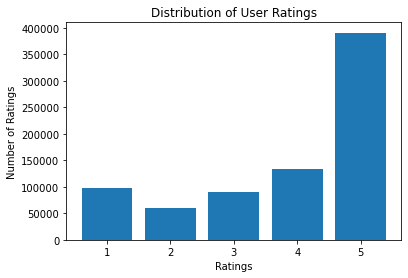

In [518]:
rating = pd.Series(data["rating"].value_counts()).sort_index()

plt.bar(rating.index, rating.values)
plt.xlabel("Ratings")
plt.ylabel("Number of Ratings")
plt.title("Distribution of User Ratings")

In [519]:
# Extract review features for importance ranking
import readability

data_tmp = data.copy() # Whole dataset

feature = pd.DataFrame()
feature["rating"] = data_tmp["rating"]
feature["vote"]  = data_tmp["vote"]
feature["length"] = data_tmp["Token_Count"]
feature["prop_of_noun"] = data_tmp["nouns"].str.len() / feature["length"]
feature["prop_of_verb"] = data_tmp["verbs"].str.len() / feature["length"]
feature["prop_of_adj_adverb"] = (data_tmp["adjs"].str.len() + data_tmp["adverbs"].str.len()) / feature["length"]
feature["subjectivity"] = data_tmp["clean"].apply(lambda x: TextBlob(x).sentiment.subjectivity)
feature["readability"] = data_tmp["reviewText"].apply(lambda x: readability.getmeasures(x, lang='en')['readability grades']['FleschReadingEase'])
feature

,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
0,5,0.0,3,0.333333,0.333333,0.333333,0.250000,97.025000
1,2,3.0,23,0.260870,0.347826,0.260870,0.428000,65.530000
2,4,0.0,27,0.333333,0.259259,0.185185,0.375000,57.153696
5,5,0.0,3,0.000000,0.333333,0.666667,0.250000,97.025000
6,4,0.0,18,0.388889,0.277778,0.222222,0.503846,69.814231
...,...,...,...,...,...,...,...,...
881895,5,0.0,24,0.250000,0.166667,0.416667,0.575397,79.406122
881896,5,2.0,23,0.347826,0.173913,0.478261,0.561896,85.865000
881897,3,0.0,4,0.250000,0.000000,0.750000,0.100000,116.145000
881898,3,0.0,5,0.200000,0.200000,0.600000,0.191667,115.130000


In [521]:
feature.corr() # No strong correlation feature pair existed

,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
rating,1.000000,-0.006585,-0.005899,0.030223,-0.035382,0.027441,0.266869,-0.047241
vote,-0.006585,1.000000,0.174822,0.001744,0.021511,-0.021423,-0.011972,-0.103001
length,-0.005899,0.174822,1.000000,-0.021725,0.101637,-0.098442,-0.057916,-0.597212
prop_of_noun,0.030223,0.001744,-0.021725,1.000000,-0.372282,-0.418303,-0.000101,-0.006674
prop_of_verb,-0.035382,0.021511,0.101637,-0.372282,1.000000,-0.435720,-0.142261,-0.024429
prop_of_adj_adverb,0.027441,-0.021423,-0.098442,-0.418303,-0.435720,1.000000,0.171021,-0.068879
subjectivity,0.266869,-0.011972,-0.057916,-0.000101,-0.142261,0.171021,1.000000,-0.070124
readability,-0.047241,-0.103001,-0.597212,-0.006674,-0.024429,-0.068879,-0.070124,1.000000


## Feature Importance

In [545]:
# Which feature best reflects user sentiment polarity (user satisfaction)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
                        feature.iloc[:,1:].to_numpy(), data_tmp["rating"].to_numpy().reshape(-1), test_size=0.2, random_state=42)

In [523]:
# Grid Search CV to find the best set of params
grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3,4,5,6,7],
    'random_state' : [18]
}

## Grid Search function
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
CV_rfr.fit(X_train, y_train)

D:\Tools\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:443: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300, 400, 500],
                         'random_state': [18]})

In [543]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",CV_rfr.best_estimator_)
print("\n The best score across ALL searched params:\n",CV_rfr.best_score_)
print("\n The best parameters across ALL searched params:\n",CV_rfr.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=300,
                      random_state=18)

 The best score across ALL searched params:
 0.11102490677414834

 The best parameters across ALL searched params:
 {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 18}


In [546]:
rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 7, random_state = 18).fit(X_train, y_train)

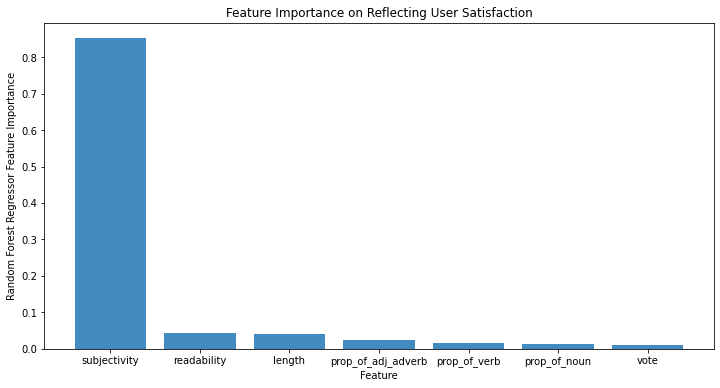

In [547]:
# Visualizations of Feature Importance
feature_name = feature.columns.values[1:][np.argsort(rf.feature_importances_)][::-1]
feature_importance = np.sort(rf.feature_importances_)[::-1]

fig = plt.figure(figsize=(12, 6))
plt.bar(feature_name, feature_importance, alpha=0.85)
plt.title("Feature Importance on Reflecting User Satisfaction")
plt.xlabel("Feature")
plt.ylabel("Random Forest Regressor Feature Importance")
plt.show()

It is observed that subjectivity has the highest feature importance on reflecting user satisfaction, followed by proportion of adjs & adverbs, length readability. This indicated that users with higher product satisfaction tended to give more subjective comments on the product, using higher portion of adjs and adverbs to highlight their feelings and satisfaction towards the product. Besides, users with higher satisfaction tended to write a longer review to document their experience in detail with higher corresponding text readability.

In [548]:
# Which features best influences review helpfulness
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
                                                        feature[["rating"] + list(feature.columns)[2:]].to_numpy(), data_tmp["vote"].to_numpy().reshape(-1), 
                                                        test_size=0.2, random_state=42)

In [527]:
# The grid search CV was costing too much time and will be ran later. For the code below, an initial set of params were used.
grid_vote = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3,4,5,6,7],
    'random_state' : [18]
}

## Grid Search function
CV_rfr_vote = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid_vote, cv= 5)
CV_rfr_vote.fit(X_train, y_train)

D:\Tools\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:443: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
D:\Tools\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:183: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300, 400, 500],
                         'random_state': [18]})

In [549]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",CV_rfr_vote.best_estimator_)
print("\n The best score across ALL searched params:\n",CV_rfr_vote.best_score_)
print("\n The best parameters across ALL searched params:\n",CV_rfr_vote.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=300,
                      random_state=18)

 The best score across ALL searched params:
 0.02472777310515848

 The best parameters across ALL searched params:
 {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 18}


In [528]:
rf_vote = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18).fit(X_train, y_train)

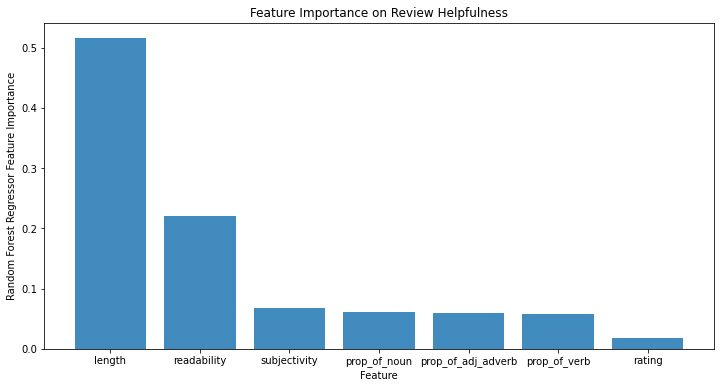

In [550]:
# Visualizations of Feature Importance
feature_name = np.array(["rating"] + list(feature.columns)[2:])[np.argsort(rf_vote.feature_importances_)][::-1]
feature_importance = np.sort(rf_vote.feature_importances_)[::-1]

fig = plt.figure(figsize=(12, 6))
plt.bar(feature_name, feature_importance, alpha=0.85)
plt.title("Feature Importance on Review Helpfulness")
plt.xlabel("Feature")
plt.ylabel("Random Forest Regressor Feature Importance")
plt.show()

Length is the most important feature that impacts review helpfulness, followed by readability, subjectivity, proportion of nouns. This implied that long reviews with good readability and subjective opinions had higher probability to be endorsed by readers since they provided more information on the product. The proportion of nouns might be correlated to the proportion of product-related feature terms mentioned in the reviews. A higher proportion of product-related feature terms indicated that more product features were discussed and evaluated in the reviews, thus providing readers with more relevant information on the product.

## Data Visualizations

In [530]:
# Aggregate current data for visualizations

feature_visual = pd.concat([data_tmp[["reviewTime","day_gap","year-month","year"]], feature], axis=1).reset_index(drop=True)
feature_visual

,reviewTime,day_gap,year-month,year,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
0,2014-10-20,1442,2014-10,2014,5,0.0,3,0.333333,0.333333,0.333333,0.250000,97.025000
1,2014-09-28,1464,2014-09,2014,2,3.0,23,0.260870,0.347826,0.260870,0.428000,65.530000
2,2014-08-25,1498,2014-08,2014,4,0.0,27,0.333333,0.259259,0.185185,0.375000,57.153696
3,2014-07-19,1535,2014-07,2014,5,0.0,3,0.000000,0.333333,0.666667,0.250000,97.025000
4,2014-05-31,1584,2014-05,2014,4,0.0,18,0.388889,0.277778,0.222222,0.503846,69.814231
...,...,...,...,...,...,...,...,...,...,...,...,...
772848,2017-02-21,587,2017-02,2017,5,0.0,24,0.250000,0.166667,0.416667,0.575397,79.406122
772849,2016-11-25,675,2016-11,2016,5,2.0,23,0.347826,0.173913,0.478261,0.561896,85.865000
772850,2016-11-10,690,2016-11,2016,3,0.0,4,0.250000,0.000000,0.750000,0.100000,116.145000
772851,2016-11-10,690,2016-11,2016,3,0.0,5,0.200000,0.200000,0.600000,0.191667,115.130000


In [531]:
# Correlation analysis

feature_visual.corr()

,day_gap,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
day_gap,1.000000,0.003456,0.079950,0.125074,-0.011171,0.035268,-0.043896,-0.002536,-0.085483
rating,0.003456,1.000000,-0.006585,-0.005899,0.030223,-0.035382,0.027441,0.266869,-0.047241
vote,0.079950,-0.006585,1.000000,0.174822,0.001744,0.021511,-0.021423,-0.011972,-0.103001
length,0.125074,-0.005899,0.174822,1.000000,-0.021725,0.101637,-0.098442,-0.057916,-0.597212
prop_of_noun,-0.011171,0.030223,0.001744,-0.021725,1.000000,-0.372282,-0.418303,-0.000101,-0.006674
prop_of_verb,0.035268,-0.035382,0.021511,0.101637,-0.372282,1.000000,-0.435720,-0.142261,-0.024429
prop_of_adj_adverb,-0.043896,0.027441,-0.021423,-0.098442,-0.418303,-0.435720,1.000000,0.171021,-0.068879
subjectivity,-0.002536,0.266869,-0.011972,-0.057916,-0.000101,-0.142261,0.171021,1.000000,-0.070124
readability,-0.085483,-0.047241,-0.103001,-0.597212,-0.006674,-0.024429,-0.068879,-0.070124,1.000000


D:\Tools\Anaconda\lib\site-packages\seaborn\matrix.py:68: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(data.shape, np.bool)
D:\Tools\Anaconda\lib\site-packages\seaborn\matrix.py:78: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.bool)


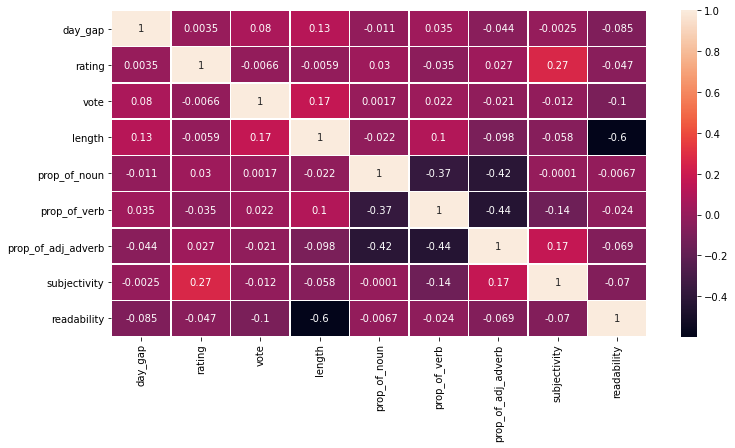

In [532]:
fig = plt.figure(figsize=(12, 6))
sns.heatmap(feature_visual.corr(), annot=True, linewidth=.5)

No strong correlation pairs existed.

In [533]:
# Trend Analysis

# Aggregate the features by year, taking mean as the aggregation method.
trend_data_by_year = feature_visual.iloc[:, 3:].groupby("year").mean().reset_index()
trend_data_by_year

,year,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
0,2002,4.200000,13.800000,85.800000,0.425157,0.152183,0.274587,0.516109,31.918511
1,2003,4.263158,2.368421,36.684211,0.334490,0.217746,0.300683,0.571253,71.498058
2,2004,3.884615,4.365385,55.596154,0.377105,0.208126,0.294887,0.528821,34.518835
3,2005,3.584416,4.558442,47.051948,0.353878,0.220581,0.272577,0.538366,46.234204
4,2006,4.051672,3.650456,38.562310,0.357493,0.215651,0.287083,0.555400,52.933711
5,2007,4.086604,1.771313,31.936401,0.362677,0.214745,0.281093,0.564790,58.975530
6,2008,4.134320,2.233553,33.376645,0.361675,0.217128,0.277604,0.578279,56.199240
7,2009,4.156132,3.026415,37.071226,0.355687,0.221855,0.280923,0.566859,54.471576
8,2010,4.107822,2.506554,38.302326,0.360164,0.223179,0.278237,0.547338,50.210647
9,2011,4.032873,2.017317,37.253889,0.358275,0.222043,0.277990,0.551164,51.975263


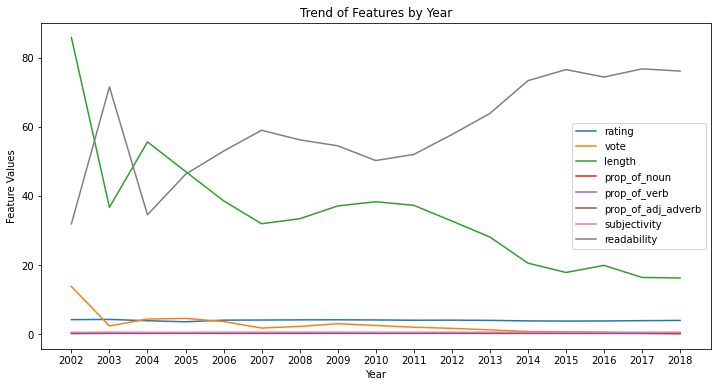

In [534]:
fig = plt.figure(figsize=(12, 6))
plt.plot(trend_data_by_year["year"], trend_data_by_year["rating"], label = "rating")
plt.plot(trend_data_by_year["year"], trend_data_by_year["vote"], label = "vote")
plt.plot(trend_data_by_year["year"], trend_data_by_year["length"], label = "length")
plt.plot(trend_data_by_year["year"], trend_data_by_year["prop_of_noun"], label = "prop_of_noun")
plt.plot(trend_data_by_year["year"], trend_data_by_year["prop_of_verb"], label = "prop_of_verb")
plt.plot(trend_data_by_year["year"], trend_data_by_year["prop_of_adj_adverb"], label = "prop_of_adj_adverb")
plt.plot(trend_data_by_year["year"], trend_data_by_year["subjectivity"], label = "subjectivity")
plt.plot(trend_data_by_year["year"], trend_data_by_year["readability"], label = "readability")
plt.xlabel("Year")
plt.ylabel("Feature Values")
plt.title("Trend of Features by Year")
plt.legend()

[Text(0, 0.5, 'Feature Values'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Trend of readability by year')]

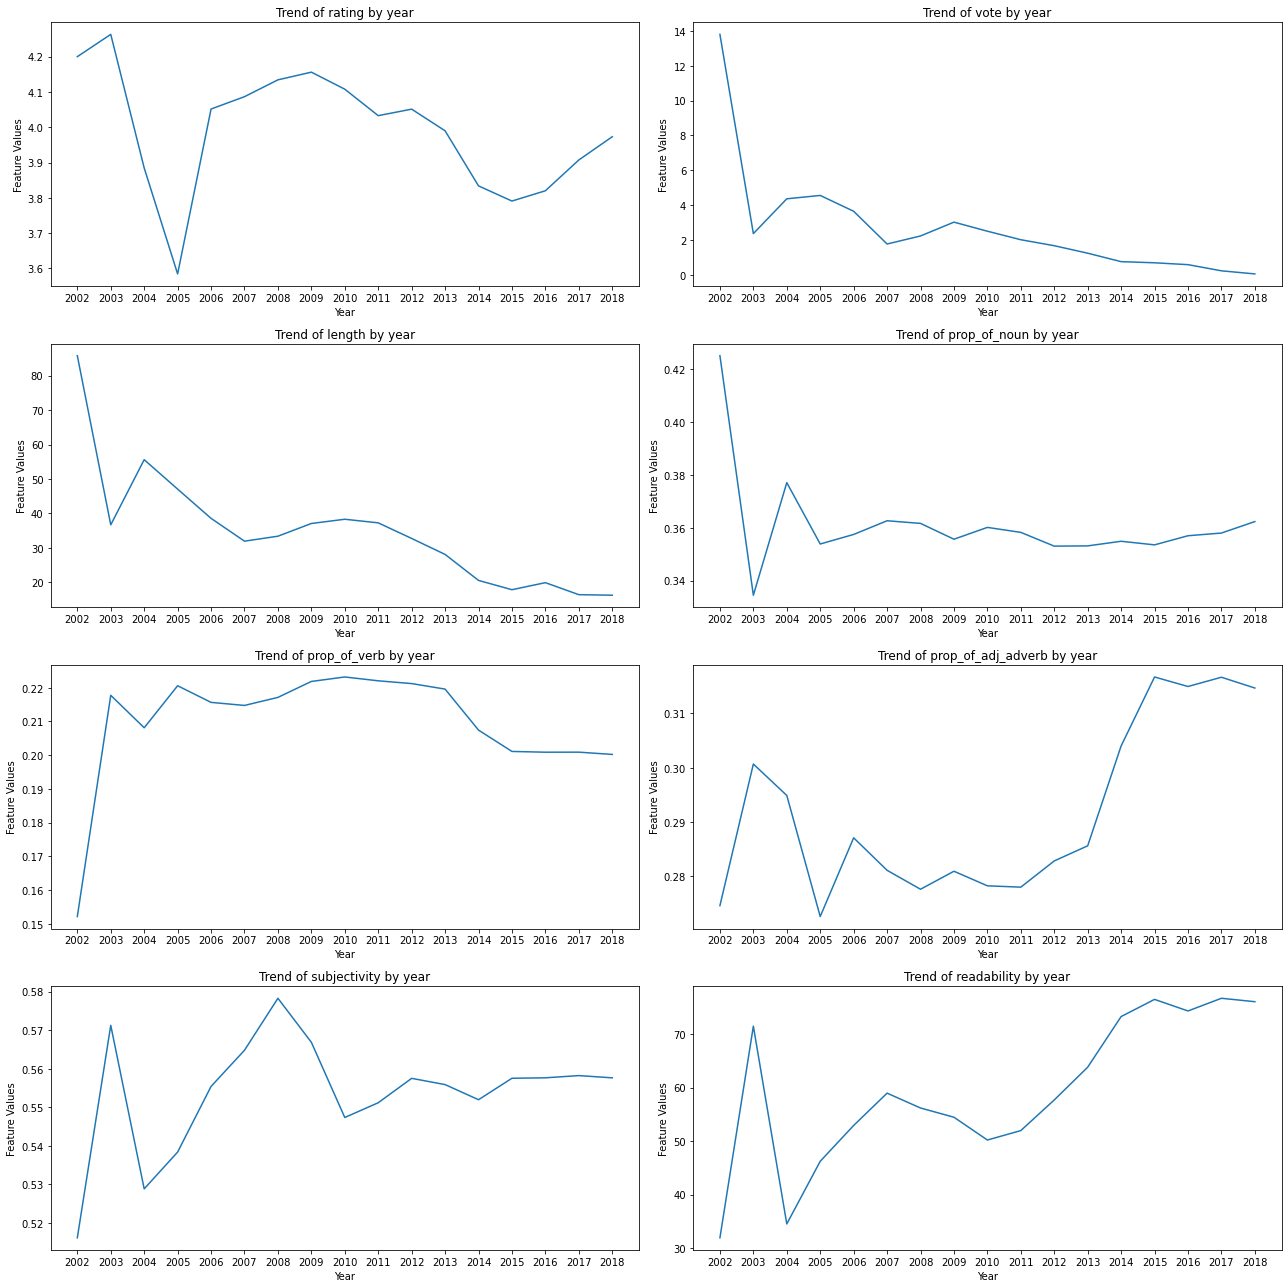

In [535]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize=(18, 18), tight_layout=True)
axes[0][0].plot(trend_data_by_year["year"], trend_data_by_year["rating"], label = "rating")
axes[0][0].set(title="Trend of rating by year", xlabel="Year", ylabel="Feature Values")
axes[0][1].plot(trend_data_by_year["year"], trend_data_by_year["vote"], label = "vote")
axes[0][1].set(title="Trend of vote by year", xlabel="Year", ylabel="Feature Values")
axes[1][0].plot(trend_data_by_year["year"], trend_data_by_year["length"], label = "length")
axes[1][0].set(title="Trend of length by year", xlabel="Year", ylabel="Feature Values")
axes[1][1].plot(trend_data_by_year["year"], trend_data_by_year["prop_of_noun"], label = "prop_of_noun")
axes[1][1].set(title="Trend of prop_of_noun by year", xlabel="Year", ylabel="Feature Values")
axes[2][0].plot(trend_data_by_year["year"], trend_data_by_year["prop_of_verb"], label = "prop_of_verb")
axes[2][0].set(title="Trend of prop_of_verb by year", xlabel="Year", ylabel="Feature Values")
axes[2][1].plot(trend_data_by_year["year"], trend_data_by_year["prop_of_adj_adverb"], label = "prop_of_adj_adverb")
axes[2][1].set(title="Trend of prop_of_adj_adverb by year", xlabel="Year", ylabel="Feature Values")
axes[3][0].plot(trend_data_by_year["year"], trend_data_by_year["subjectivity"], label = "subjectivity")
axes[3][0].set(title="Trend of subjectivity by year", xlabel="Year", ylabel="Feature Values")
axes[3][1].plot(trend_data_by_year["year"], trend_data_by_year["readability"], label = "readability")
axes[3][1].set(title="Trend of readability by year", xlabel="Year", ylabel="Feature Values")

From the graph, there exist a general decreasing trend in rating, vote, length. Consumers might be more sensitive to product quality and write more succinct reviews. Also, the prop_of_adj_adverb and readability observed an increasing trend. Consumers might be expressing more personal and subjective experiences. With shorter reviews on average, the readability also increased accordingly.

In [536]:
# Aggregate the features by year & month, taking mean as the aggregation method.
trend_data_by_year_month = feature_visual.iloc[:, 2:].groupby("year-month").mean().reset_index()
trend_data_by_year_month

,year-month,rating,vote,length,prop_of_noun,prop_of_verb,prop_of_adj_adverb,subjectivity,readability
0,2002-11,4.000000,22.333333,121.000000,0.426543,0.182413,0.256315,0.496154,22.187515
1,2002-12,4.500000,1.000000,33.000000,0.423077,0.106838,0.301994,0.546042,46.515004
2,2003-01,4.000000,2.000000,36.000000,0.250000,0.277778,0.361111,0.543537,65.048432
3,2003-02,4.000000,2.500000,40.500000,0.454907,0.191976,0.226459,0.518286,58.974375
4,2003-03,4.666667,0.000000,47.333333,0.343834,0.166911,0.318681,0.443439,68.554675
...,...,...,...,...,...,...,...,...,...
183,2018-06,4.025548,0.032793,16.580744,0.364322,0.198142,0.317950,0.564798,74.827791
184,2018-07,3.994136,0.032983,16.214024,0.366829,0.199140,0.312636,0.551207,76.182614
185,2018-08,3.991377,0.035088,15.688076,0.368896,0.197335,0.315046,0.549208,76.385344
186,2018-09,3.973803,0.027100,16.793135,0.367642,0.193373,0.320393,0.552489,73.898460


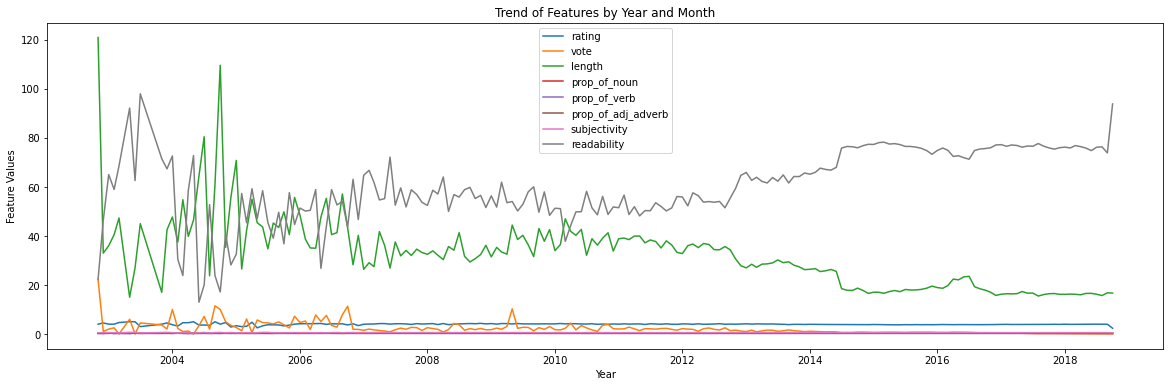

In [537]:
fig = plt.figure(figsize=(20, 6))
year_month = np.asarray(trend_data_by_year_month["year-month"], dtype='datetime64[s]')
plt.plot(year_month, trend_data_by_year_month["rating"], label = "rating")
plt.plot(year_month, trend_data_by_year_month["vote"], label = "vote")
plt.plot(year_month, trend_data_by_year_month["length"], label = "length")
plt.plot(year_month, trend_data_by_year_month["prop_of_noun"], label = "prop_of_noun")
plt.plot(year_month, trend_data_by_year_month["prop_of_verb"], label = "prop_of_verb")
plt.plot(year_month, trend_data_by_year_month["prop_of_adj_adverb"], label = "prop_of_adj_adverb")
plt.plot(year_month, trend_data_by_year_month["subjectivity"], label = "subjectivity")
plt.plot(year_month, trend_data_by_year_month["readability"], label = "readability")
plt.xlabel("Year")
plt.ylabel("Feature Values")
#plt.xticks(rotation = 90)
plt.title("Trend of Features by Year and Month")
plt.legend()

[Text(0, 0.5, 'Feature Values'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Trend of readability by year and month')]

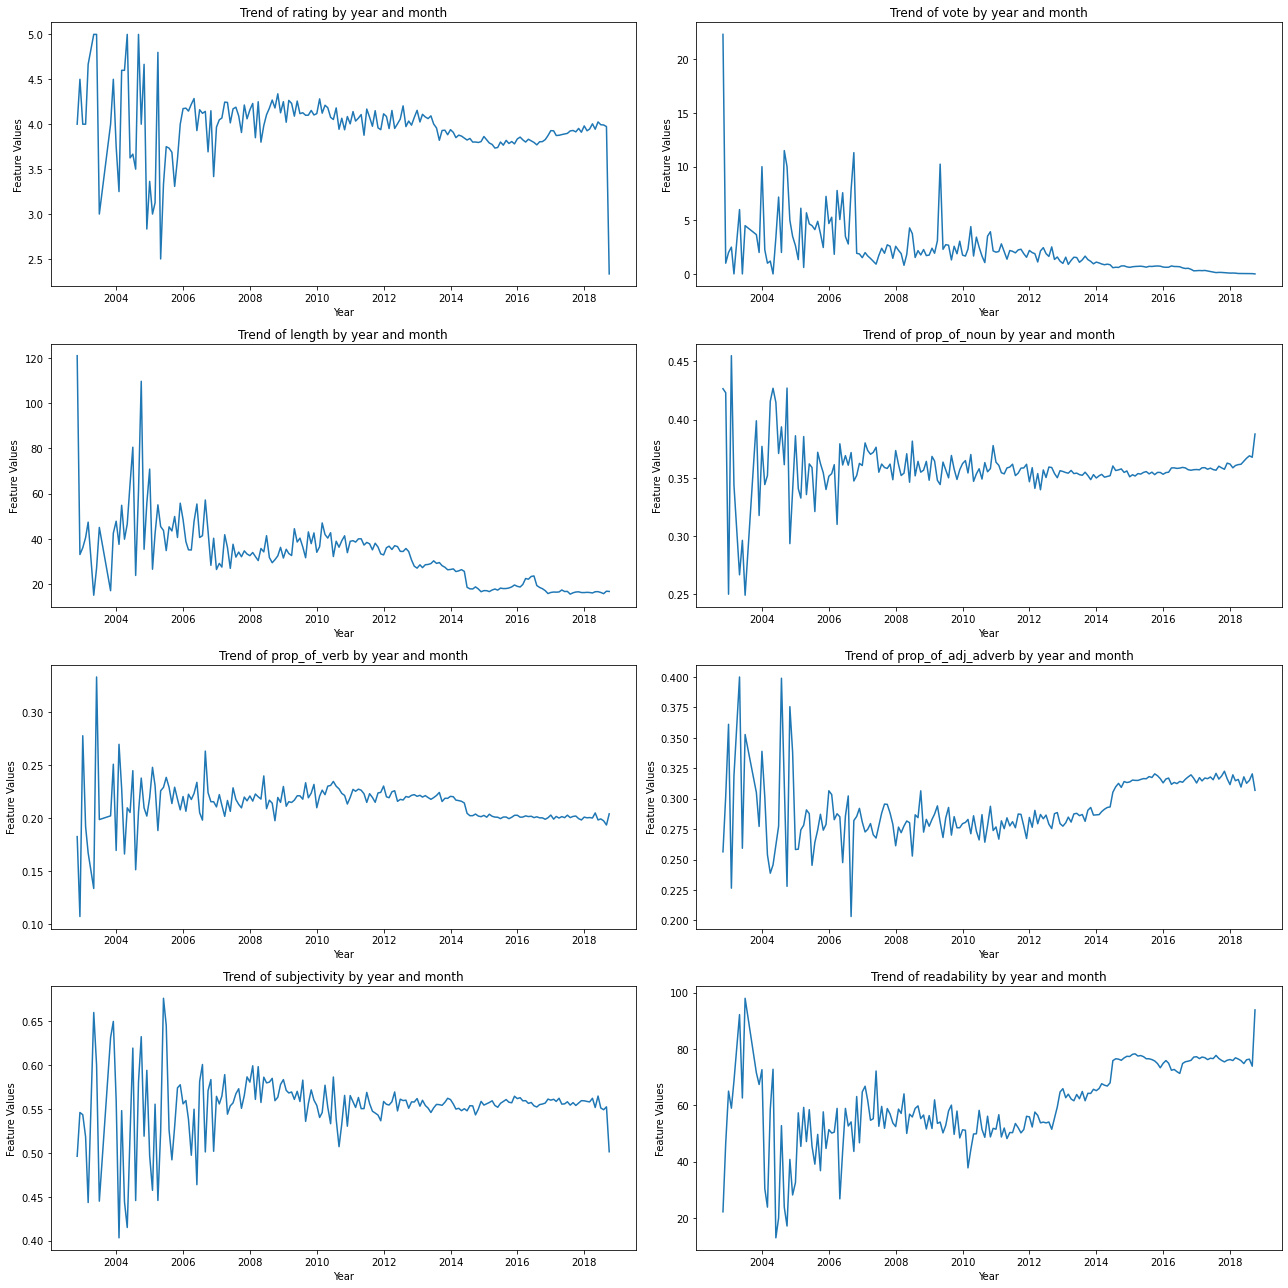

In [538]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize=(18, 18), tight_layout=True)
axes[0][0].plot(year_month, trend_data_by_year_month["rating"], label = "rating")
axes[0][0].set(title="Trend of rating by year and month", xlabel="Year", ylabel="Feature Values")
axes[0][1].plot(year_month, trend_data_by_year_month["vote"], label = "vote")
axes[0][1].set(title="Trend of vote by year and month", xlabel="Year", ylabel="Feature Values")
axes[1][0].plot(year_month, trend_data_by_year_month["length"], label = "length")
axes[1][0].set(title="Trend of length by year and month", xlabel="Year", ylabel="Feature Values")
axes[1][1].plot(year_month, trend_data_by_year_month["prop_of_noun"], label = "prop_of_noun")
axes[1][1].set(title="Trend of prop_of_noun by year and month", xlabel="Year", ylabel="Feature Values")
axes[2][0].plot(year_month, trend_data_by_year_month["prop_of_verb"], label = "prop_of_verb")
axes[2][0].set(title="Trend of prop_of_verb by year and month", xlabel="Year", ylabel="Feature Values")
axes[2][1].plot(year_month, trend_data_by_year_month["prop_of_adj_adverb"], label = "prop_of_adj_adverb")
axes[2][1].set(title="Trend of prop_of_adj_adverb by year and month", xlabel="Year", ylabel="Feature Values")
axes[3][0].plot(year_month, trend_data_by_year_month["subjectivity"], label = "subjectivity")
axes[3][0].set(title="Trend of subjectivity by year and month", xlabel="Year", ylabel="Feature Values")
axes[3][1].plot(year_month, trend_data_by_year_month["readability"], label = "readability")
axes[3][1].set(title="Trend of readability by year and month", xlabel="Year", ylabel="Feature Values")